# ATM Cash Demand Forecasting - ML Model Training

## Week 2-3: Model Development

This notebook:
1. Implements 3 forecasting models: ARIMA, LSTM, Prophet
2. Performs train-test split
3. Trains and evaluates each model
4. Creates ensemble model
5. Saves trained models

In [22]:
# Import required libraries
import sys
import os

# Add project root to path
project_root = r'C:\Users\bdevr\Project\smart-atm-system'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting
%matplotlib inline

from ml_models.forecasting_models import (
    ARIMAForecaster, 
    LSTMForecaster, 
    ProphetForecaster,
    EnsembleForecaster,
    train_all_models
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"✓ Project root: {project_root}")

✓ Libraries imported successfully
✓ Project root: C:\Users\bdevr\Project\smart-atm-system


## 1. Load and Prepare Data

In [23]:
# Load data
df = pd.read_csv('../ml_models/data/atm_demand_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nATMs in dataset:")
for atm_id in df['atm_id'].unique():
    atm_name = df[df['atm_id'] == atm_id]['atm_name'].iloc[0]
    print(f"  {atm_id}. {atm_name}")

Dataset loaded: (1444, 18)
Date range: 2024-11-08 00:00:00 to 2025-11-03 00:00:00

ATMs in dataset:
  1. ATM Mall Plaza
  2. ATM University
  3. ATM Airport
  4. ATM Hospital


Training models for: ATM Mall Plaza
Total data points: 361


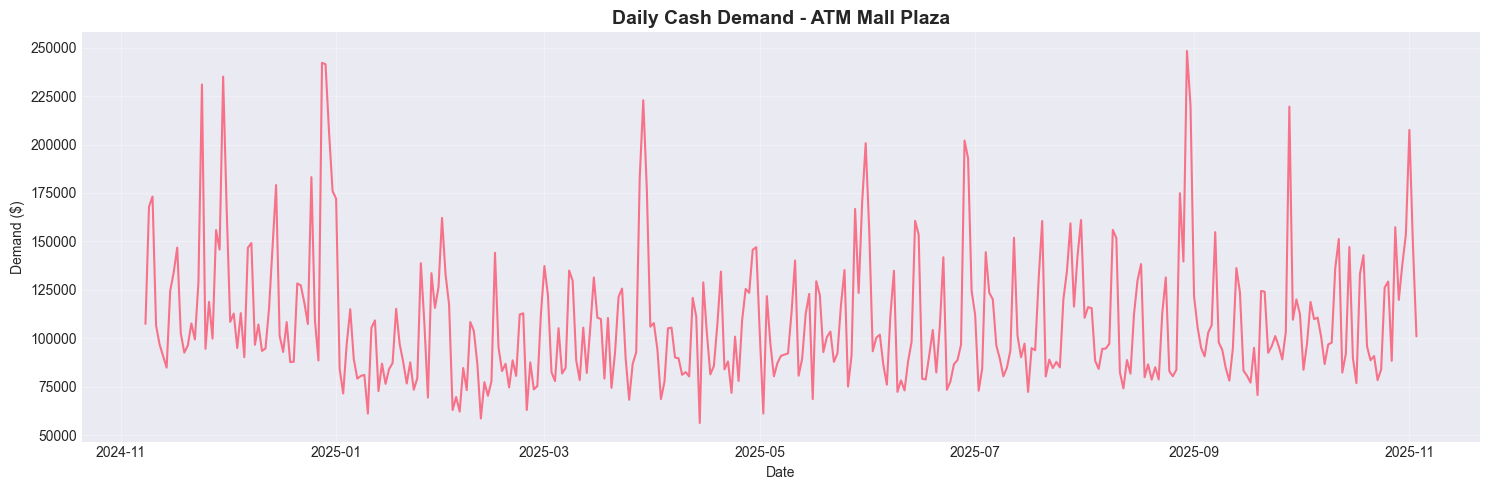

In [24]:
# Select one ATM for detailed training example
ATM_ID = 1  # Mall Plaza - has interesting patterns
atm_data = df[df['atm_id'] == ATM_ID].sort_values('date').reset_index(drop=True)
atm_name = atm_data['atm_name'].iloc[0]

print(f"Training models for: {atm_name}")
print(f"Total data points: {len(atm_data)}")

# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(atm_data['date'], atm_data['total_demand'], linewidth=1.5)
plt.title(f'Daily Cash Demand - {atm_name}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Train-Test Split

Split data: 80% training, 20% testing

In [4]:
# Train-test split (80-20)
train_size = int(len(atm_data) * 0.8)
train_data = atm_data['total_demand'].values[:train_size]
test_data = atm_data['total_demand'].values[train_size:]

train_dates = atm_data['date'].values[:train_size]
test_dates = atm_data['date'].values[train_size:]

print(f"Training data: {len(train_data)} days ({train_dates[0]} to {train_dates[-1]})")
print(f"Testing data: {len(test_data)} days ({test_dates[0]} to {test_dates[-1]})")
print(f"\nTrain mean: ${train_data.mean():,.0f}")
print(f"Test mean: ${test_data.mean():,.0f}")

Training data: 288 days (2024-11-08T00:00:00.000000000 to 2025-08-22T00:00:00.000000000)
Testing data: 73 days (2025-08-23T00:00:00.000000000 to 2025-11-03T00:00:00.000000000)

Train mean: $107,719
Test mean: $114,011


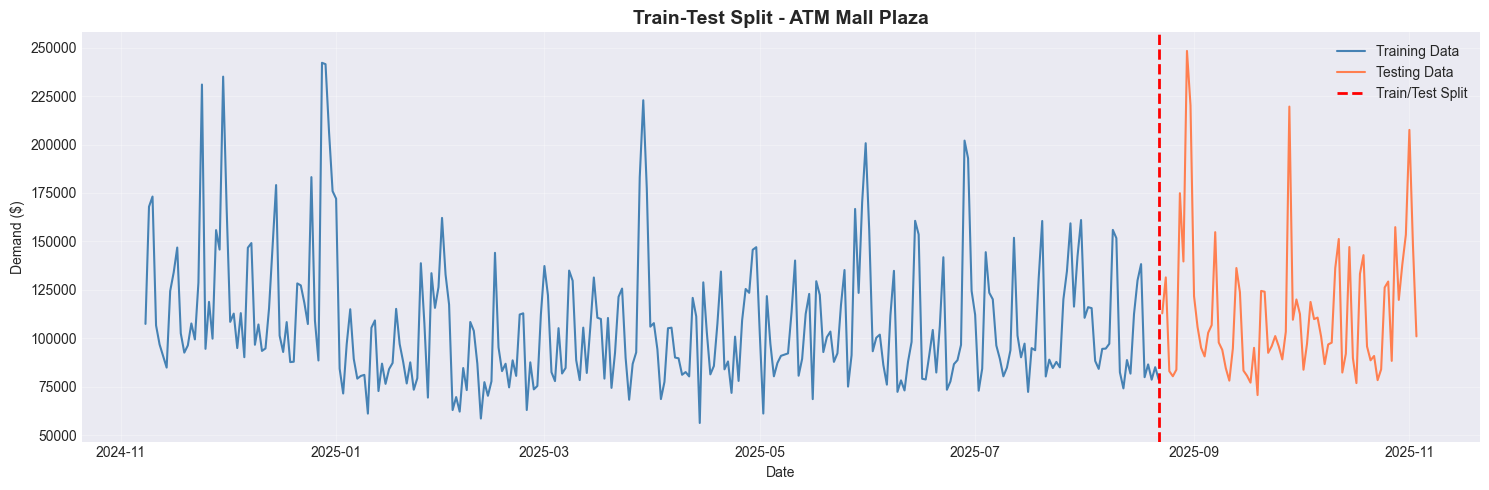

In [5]:
# Visualize split
plt.figure(figsize=(15, 5))
plt.plot(train_dates, train_data, label='Training Data', linewidth=1.5, color='steelblue')
plt.plot(test_dates, test_data, label='Testing Data', linewidth=1.5, color='coral')
plt.axvline(x=train_dates[-1], color='red', linestyle='--', linewidth=2, label='Train/Test Split')
plt.title(f'Train-Test Split - {atm_name}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Model Training

### 3.1 ARIMA Model (Baseline)

In [28]:
# Train ARIMA
print("=" * 60)
print("TRAINING ARIMA MODEL")
print("=" * 60)

arima_model = ARIMAForecaster(order=(5, 1, 2))
arima_model.train(train_data, verbose=True)

# Make predictions
arima_predictions = arima_model.predict(steps=len(test_data))

# Evaluate
arima_metrics = arima_model.calculate_metrics(test_data, arima_predictions)
print(f"\n✓ ARIMA Evaluation Metrics:")
for metric, value in arima_metrics.items():
    print(f"  {metric}: {value}")

TRAINING ARIMA MODEL

=== Training ARIMA Model ===
ADF Statistic: -3.8268
p-value: 0.0026
Series is stationary
✓ ARIMA model trained successfully
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  288
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3351.822
Date:                Mon, 03 Nov 2025   AIC                           6719.643
Time:                        01:38:39   BIC                           6748.919
Sample:                             0   HQIC                          6731.377
                                - 288                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2008      0.116      1.725      0.085      -0.0

### 3.2 LSTM Model (Deep Learning)

TRAINING LSTM MODEL

=== Training LSTM Model ===
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0503 - val_loss: 0.0370
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0382 - val_loss: 0.0269
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0345 - val_loss: 0.0250
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0313 - val_loss: 0.0237
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0332 - val_loss: 0.0232
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0314 - val_loss: 0.0240
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0318 - val_loss: 0.0230
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0314 - val_loss: 0.0231
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0313 - val_loss: 0.0231
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0311 - val_loss: 0.0229
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0323 - val_loss: 0.0233
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━

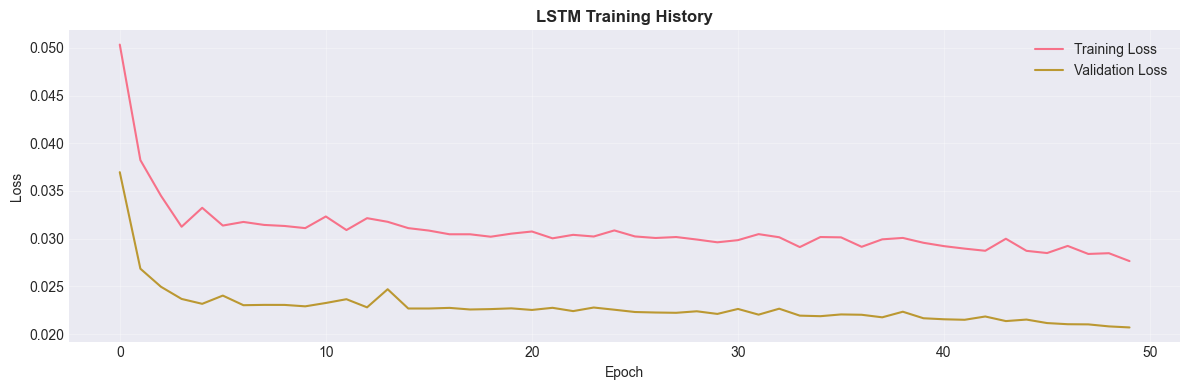

In [27]:
# Train LSTM
print("=" * 60)
print("TRAINING LSTM MODEL")
print("=" * 60)

try:
    lstm_model = LSTMForecaster(lookback=30, units=50)
    history = lstm_model.train(train_data, epochs=50, batch_size=32, verbose=True)
    
    # Make predictions
    full_data = np.concatenate([train_data, test_data])
    recent_data = full_data[train_size-30:train_size]
    lstm_predictions = lstm_model.predict(recent_data, steps=len(test_data))
    
    # Evaluate
    lstm_metrics = lstm_model.calculate_metrics(test_data, lstm_predictions)
    print(f"\n✓ LSTM Evaluation Metrics:")
    for metric, value in lstm_metrics.items():
        print(f"  {metric}: {value}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training History', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    lstm_available = True
except Exception as e:
    print(f"✗ LSTM training failed: {e}")
    print("  Continuing with available models...")
    lstm_available = False

In [26]:
# Test TensorFlow import directly
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    print(f"✓ TensorFlow {tf.__version__} is available!")
    print("✓ Keras imports successful!")
    
    # Reload the forecasting_models module to pick up changes
    import importlib
    import ml_models.forecasting_models as fm
    importlib.reload(fm)
    print("✓ forecasting_models module reloaded!")
    
    # Now import the classes
    from ml_models.forecasting_models import LSTMForecaster
    print("✓ LSTMForecaster imported successfully!")
except Exception as e:
    print(f"✗ Error: {e}")
    import traceback
    traceback.print_exc()

✓ TensorFlow 2.20.0 is available!
✓ Keras imports successful!
✓ forecasting_models module reloaded!
✓ LSTMForecaster imported successfully!


### 3.3 Prophet Model (Facebook's Time Series)

In [9]:
# Train Prophet
print("=" * 60)
print("TRAINING PROPHET MODEL")
print("=" * 60)

try:
    prophet_model = ProphetForecaster()
    
    # Prepare data for Prophet
    train_df = pd.DataFrame({
        'ds': train_dates,
        'y': train_data
    })
    
    test_df = pd.DataFrame({
        'ds': test_dates,
        'y': test_data
    })
    
    prophet_model.train(train_df, verbose=True)
    
    # Make predictions
    prophet_predictions = prophet_model.predict(periods=len(test_data))
    
    # Evaluate
    prophet_metrics = prophet_model.calculate_metrics(test_data, prophet_predictions)
    print(f"\n✓ Prophet Evaluation Metrics:")
    for metric, value in prophet_metrics.items():
        print(f"  {metric}: {value}")
    
    prophet_available = True
except Exception as e:
    print(f"✗ Prophet training failed: {e}")
    print("  Continuing with available models...")
    prophet_available = False

TRAINING PROPHET MODEL
✗ Prophet training failed: Prophet is required. Install with: pip install prophet
  Continuing with available models...


## 4. Model Comparison

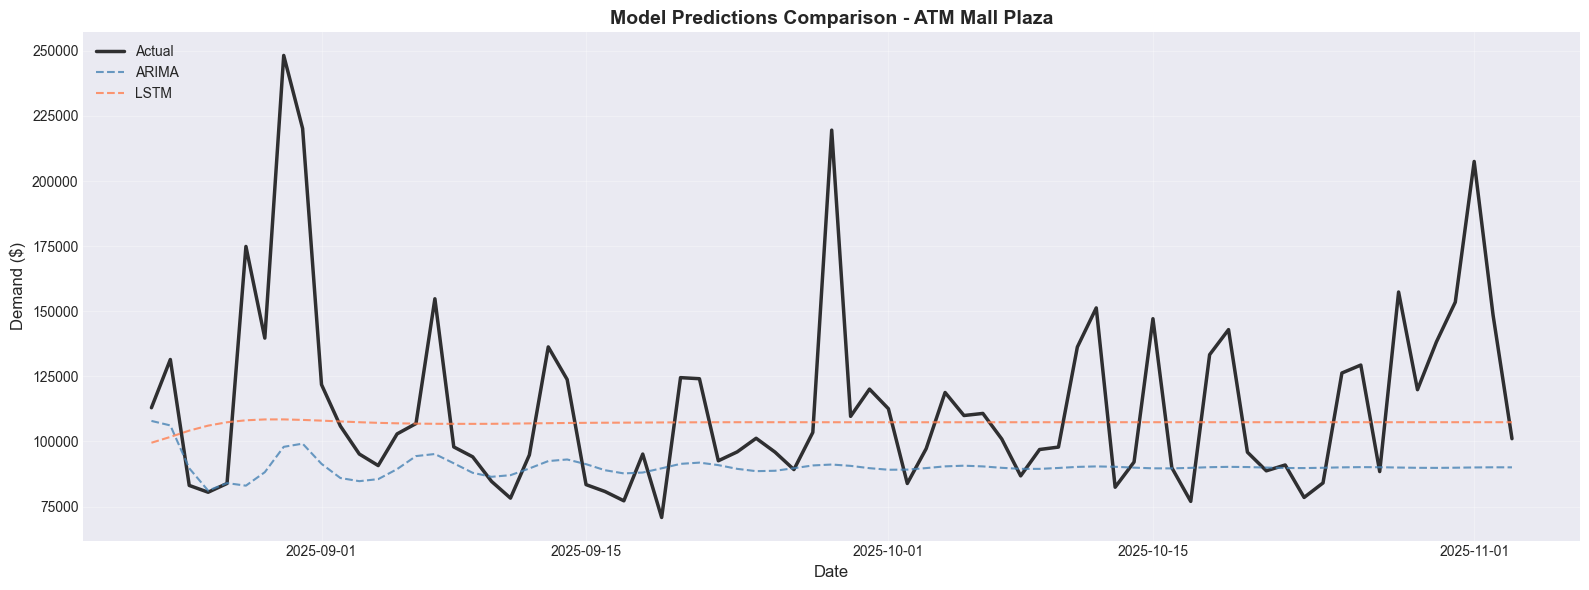

In [29]:
# Compile all predictions
predictions_dict = {
    'Actual': test_data,
    'ARIMA': arima_predictions
}

if lstm_available:
    predictions_dict['LSTM'] = lstm_predictions
if prophet_available:
    predictions_dict['Prophet'] = prophet_predictions

# Plot predictions
plt.figure(figsize=(16, 6))
colors = ['black', 'steelblue', 'coral', 'green']
styles = ['-', '--', '--', '--']
widths = [2.5, 1.5, 1.5, 1.5]

for idx, (name, values) in enumerate(predictions_dict.items()):
    plt.plot(test_dates, values, label=name, 
             color=colors[idx % len(colors)], 
             linestyle=styles[idx % len(styles)],
             linewidth=widths[idx % len(widths)],
             alpha=0.8)

plt.title(f'Model Predictions Comparison - {atm_name}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand ($)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Metrics comparison
metrics_comparison = pd.DataFrame({
    'ARIMA': arima_metrics
})

if lstm_available:
    metrics_comparison['LSTM'] = lstm_metrics
if prophet_available:
    metrics_comparison['Prophet'] = prophet_metrics

print("\n" + "=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(metrics_comparison.T)

# Determine best model
best_model = metrics_comparison.T['MAPE'].idxmin()
print(f"\n🏆 BEST MODEL: {best_model} (Lowest MAPE: {metrics_comparison.T.loc[best_model, 'MAPE']:.2f}%)")
print("=" * 60)


MODEL PERFORMANCE COMPARISON
            MAE      RMSE   MAPE      R2
ARIMA  26839.81  41731.59  19.05 -0.3848
LSTM   25434.72  35979.71  20.64 -0.0294

🏆 BEST MODEL: ARIMA (Lowest MAPE: 19.05%)


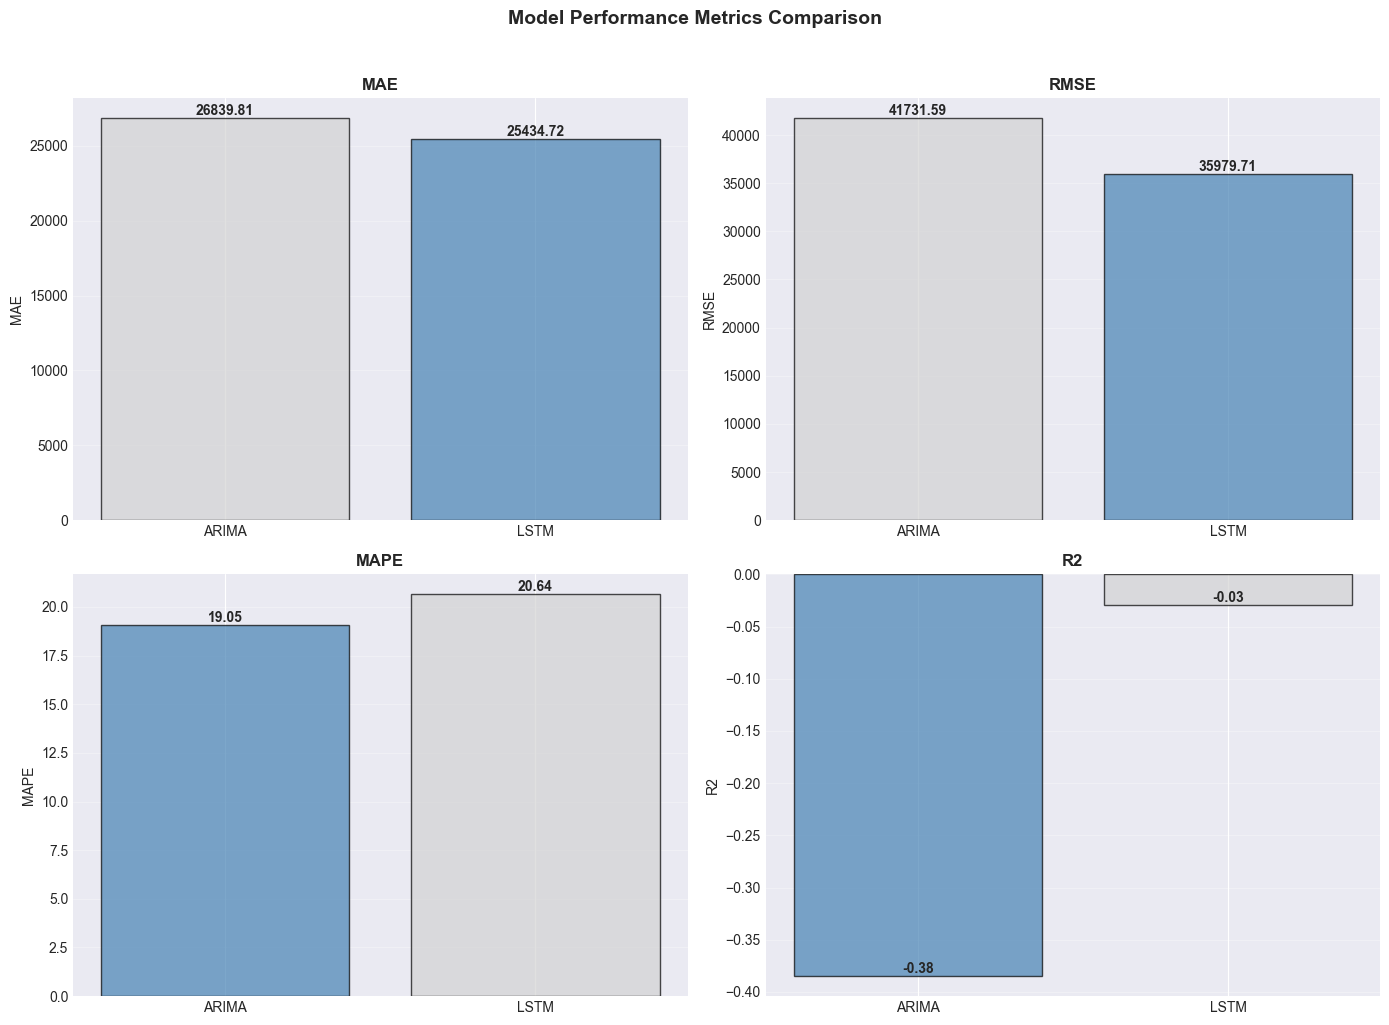

In [31]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['MAE', 'RMSE', 'MAPE', 'R2']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = metrics_comparison.loc[metric]
    colors_bar = ['steelblue' if v == values.min() else 'lightgray' for v in values]
    
    bars = ax.bar(values.index, values.values, color=colors_bar, edgecolor='black', alpha=0.7)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 5. Ensemble Model

In [32]:
# Create ensemble
print("=" * 60)
print("CREATING ENSEMBLE MODEL")
print("=" * 60)

models_list = [arima_model]
model_names = ['ARIMA']

if lstm_available:
    models_list.append(lstm_model)
    model_names.append('LSTM')
if prophet_available:
    models_list.append(prophet_model)
    model_names.append('Prophet')

# Equal weights for simplicity (can be optimized based on performance)
ensemble = EnsembleForecaster(models_list)

# Make ensemble predictions
if lstm_available:
    ensemble_predictions = ensemble.predict(steps=len(test_data), recent_data=recent_data)
else:
    ensemble_predictions = ensemble.predict(steps=len(test_data))

# Evaluate ensemble
if lstm_available:
    ensemble_metrics = ensemble.evaluate(test_data, recent_data=recent_data)
else:
    ensemble_metrics = ensemble.evaluate(test_data)

print(f"\n✓ Ensemble Model (combining {', '.join(model_names)})")
print(f"\nEnsemble Evaluation Metrics:")
for metric, value in ensemble_metrics.items():
    print(f"  {metric}: {value}")

print("=" * 60)

CREATING ENSEMBLE MODEL

✓ Ensemble Model (combining ARIMA, LSTM)

Ensemble Evaluation Metrics:
  MAE: 24539.81
  RMSE: 37967.32
  MAPE: 18.2
  R2: -0.1463


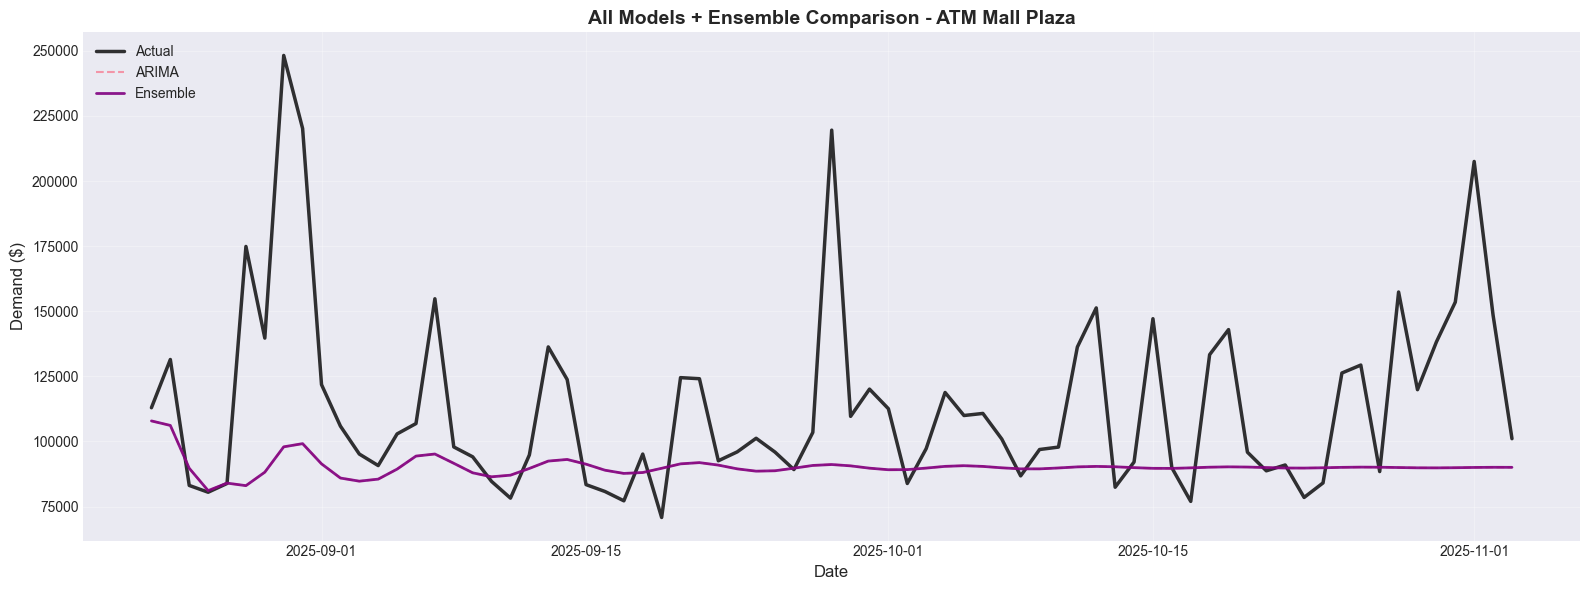

In [14]:
# Plot with ensemble
plt.figure(figsize=(16, 6))
plt.plot(test_dates, test_data, label='Actual', color='black', linewidth=2.5, alpha=0.8)
plt.plot(test_dates, arima_predictions, label='ARIMA', linestyle='--', linewidth=1.5, alpha=0.7)

if lstm_available:
    plt.plot(test_dates, lstm_predictions, label='LSTM', linestyle='--', linewidth=1.5, alpha=0.7)
if prophet_available:
    plt.plot(test_dates, prophet_predictions, label='Prophet', linestyle='--', linewidth=1.5, alpha=0.7)

plt.plot(test_dates, ensemble_predictions, label='Ensemble', 
         color='purple', linewidth=2, linestyle='-', alpha=0.9)

plt.title(f'All Models + Ensemble Comparison - {atm_name}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand ($)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Save Models

In [36]:
# Save all trained models
import os
import joblib  # Use joblib instead of pickle for sklearn/ML models

models_dir = '../ml_models/saved_models/'
os.makedirs(models_dir, exist_ok=True)

print("\n" + "=" * 60)
print("SAVING TRAINED MODELS")
print("=" * 60)

# Save ARIMA (save the FITTED model, not the ARIMA object)
joblib.dump(arima_model.fitted_model, f'{models_dir}arima_atm_{ATM_ID}.pkl')
print(f"✓ ARIMA fitted model saved")

# Save LSTM if available (save BOTH the Keras model AND the scaler)
if lstm_available:
    lstm_package = {
        'model': lstm_model.model,
        'scaler': lstm_model.scaler,
        'lookback': lstm_model.lookback,
        'units': lstm_model.units
    }
    joblib.dump(lstm_package, f'{models_dir}lstm_atm_{ATM_ID}.pkl')
    print(f"✓ LSTM model and scaler saved")

# Save Prophet if available
if prophet_available:
    joblib.dump(prophet_model.model, f'{models_dir}prophet_atm_{ATM_ID}.pkl')
    print(f"✓ Prophet model saved")

# Save ensemble model info
ensemble_info = {
    'model_names': model_names,
    'weights': ensemble.weights if hasattr(ensemble, 'weights') else None
}
joblib.dump(ensemble_info, f'{models_dir}ensemble_atm_{ATM_ID}.pkl')
print(f"✓ Ensemble model info saved")

# Save metrics
metrics_comparison.to_csv(f'{models_dir}model_metrics_atm_{ATM_ID}.csv')
print(f"✓ Metrics saved to CSV")

print("\n" + "=" * 60)
print("MODEL TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest performing model: {best_model}")
print(f"Models saved to: {models_dir}")
print("\n✓ Ready for API deployment!")
print("=" * 60)


SAVING TRAINED MODELS
✓ ARIMA fitted model saved
✓ LSTM model and scaler saved
✓ Ensemble model info saved
✓ Metrics saved to CSV

MODEL TRAINING COMPLETE

Best performing model: ARIMA
Models saved to: ../ml_models/saved_models/

✓ Ready for API deployment!


## 6. Train Models for All ATMs

Now let's train models for all remaining ATMs (2, 3, 4)

In [37]:
# Train models for all ATMs (2, 3, 4)
# ATM 1 is already trained above

remaining_atms = [2, 3, 4]

for atm_id in remaining_atms:
    print("\n" + "=" * 80)
    print(f"TRAINING MODELS FOR ATM {atm_id}")
    print("=" * 80)
    
    # Get ATM data
    atm_data_current = df[df['atm_id'] == atm_id].sort_values('date').reset_index(drop=True)
    atm_name_current = atm_data_current['atm_name'].iloc[0]
    
    print(f"\nATM: {atm_name_current}")
    print(f"Data points: {len(atm_data_current)}")
    
    # Train-test split
    train_size_current = int(len(atm_data_current) * 0.8)
    train_data_current = atm_data_current['total_demand'].values[:train_size_current]
    test_data_current = atm_data_current['total_demand'].values[train_size_current:]
    
    print(f"Training samples: {len(train_data_current)}")
    print(f"Testing samples: {len(test_data_current)}")
    
    # 1. Train ARIMA
    print("\n" + "-" * 60)
    print("Training ARIMA...")
    print("-" * 60)
    try:
        arima_model_current = ARIMAForecaster(order=(5, 1, 2))
        arima_model_current.train(train_data_current)
        arima_predictions_current = arima_model_current.predict(steps=len(test_data_current))
        arima_metrics_current = arima_model_current.calculate_metrics(test_data_current, arima_predictions_current)
        
        print(f"✓ ARIMA trained successfully!")
        print(f"  MAE: ${arima_metrics_current['MAE']:,.2f}")
        print(f"  RMSE: ${arima_metrics_current['RMSE']:,.2f}")
        print(f"  MAPE: {arima_metrics_current['MAPE']:.2f}%")
        
        # Save ARIMA model
        joblib.dump(arima_model_current.fitted_model, f'{models_dir}arima_atm_{atm_id}.pkl')
        print(f"✓ ARIMA model saved")
        
        arima_success = True
    except Exception as e:
        print(f"✗ ARIMA training failed: {e}")
        arima_success = False
    
    # 2. Train LSTM
    print("\n" + "-" * 60)
    print("Training LSTM...")
    print("-" * 60)
    try:
        lstm_model_current = LSTMForecaster(lookback=30, units=50)
        history_current = lstm_model_current.train(train_data_current, epochs=50, batch_size=32, verbose=False)
        
        # Make predictions
        full_data_current = np.concatenate([train_data_current, test_data_current])
        recent_data_current = full_data_current[train_size_current-30:train_size_current]
        lstm_predictions_current = lstm_model_current.predict(recent_data_current, steps=len(test_data_current))
        
        # Evaluate
        lstm_metrics_current = lstm_model_current.calculate_metrics(test_data_current, lstm_predictions_current)
        
        print(f"✓ LSTM trained successfully!")
        print(f"  MAE: ${lstm_metrics_current['MAE']:,.2f}")
        print(f"  RMSE: ${lstm_metrics_current['RMSE']:,.2f}")
        print(f"  MAPE: {lstm_metrics_current['MAPE']:.2f}%")
        
        # Save LSTM model with scaler
        lstm_package_current = {
            'model': lstm_model_current.model,
            'scaler': lstm_model_current.scaler,
            'lookback': lstm_model_current.lookback,
            'units': lstm_model_current.units
        }
        joblib.dump(lstm_package_current, f'{models_dir}lstm_atm_{atm_id}.pkl')
        print(f"✓ LSTM model and scaler saved")
        
        lstm_success = True
    except Exception as e:
        print(f"✗ LSTM training failed: {e}")
        lstm_success = False
    
    # 3. Create Ensemble
    if arima_success and lstm_success:
        print("\n" + "-" * 60)
        print("Creating Ensemble...")
        print("-" * 60)
        
        try:
            # Create ensemble with equal weights
            models_list_current = [arima_model_current, lstm_model_current]
            model_names_current = ['ARIMA', 'LSTM']
            
            ensemble_current = EnsembleForecaster(models_list_current, weights=[0.5, 0.5])
            ensemble_predictions_current = ensemble_current.predict(recent_data_current, steps=len(test_data_current))
            ensemble_metrics_current = ensemble_current.calculate_metrics(test_data_current, ensemble_predictions_current)
            
            print(f"✓ Ensemble created successfully!")
            print(f"  MAE: ${ensemble_metrics_current['MAE']:,.2f}")
            print(f"  RMSE: ${ensemble_metrics_current['RMSE']:,.2f}")
            print(f"  MAPE: {ensemble_metrics_current['MAPE']:.2f}%")
            
            # Save ensemble info
            ensemble_info_current = {
                'model_names': model_names_current,
                'weights': [0.5, 0.5]
            }
            joblib.dump(ensemble_info_current, f'{models_dir}ensemble_atm_{atm_id}.pkl')
            print(f"✓ Ensemble info saved")
            
            # Save metrics comparison
            metrics_comparison_current = pd.DataFrame({
                'ARIMA': arima_metrics_current,
                'LSTM': lstm_metrics_current,
                'Ensemble': ensemble_metrics_current
            })
            metrics_comparison_current.to_csv(f'{models_dir}model_metrics_atm_{atm_id}.csv')
            print(f"✓ Metrics saved to CSV")
            
        except Exception as e:
            print(f"✗ Ensemble creation failed: {e}")
    else:
        print("\n⚠ Skipping ensemble - not all models trained successfully")

print("\n" + "=" * 80)
print("✓ ALL ATMs TRAINING COMPLETE!")
print("=" * 80)


TRAINING MODELS FOR ATM 2

ATM: ATM University
Data points: 361
Training samples: 288
Testing samples: 73

------------------------------------------------------------
Training ARIMA...
------------------------------------------------------------

=== Training ARIMA Model ===
ADF Statistic: -5.6682
p-value: 0.0000
Series is stationary
✓ ARIMA model trained successfully
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  288
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3203.000
Date:                Mon, 03 Nov 2025   AIC                           6422.000
Time:                        02:29:14   BIC                           6451.276
Sample:                             0   HQIC                          6433.734
                                - 288                                         
Covariance Type:                  opg                                     

In [38]:
# Create ensemble files and metrics for ATMs 2, 3, 4 manually
import joblib
import pandas as pd

for atm_id in [2, 3, 4]:
    print(f"\nProcessing ATM {atm_id}...")
    
    # Check if ARIMA and LSTM models exist
    arima_file = f'{models_dir}arima_atm_{atm_id}.pkl'
    lstm_file = f'{models_dir}lstm_atm_{atm_id}.pkl'
    
    if os.path.exists(arima_file) and os.path.exists(lstm_file):
        # Load models to test them
        try:
            # Load ARIMA
            arima_fitted = joblib.load(arima_file)
            arima_test = ARIMAForecaster(order=(5, 1, 2))
            arima_test.fitted_model = arima_fitted
            arima_test.is_trained = True
            print(f"  ✓ ARIMA model loaded")
            
            # Load LSTM
            lstm_pkg = joblib.load(lstm_file)
            lstm_test = LSTMForecaster(lookback=lstm_pkg['lookback'], units=lstm_pkg['units'])
            lstm_test.model = lstm_pkg['model']
            lstm_test.scaler = lstm_pkg['scaler']
            lstm_test.is_trained = True
            print(f"  ✓ LSTM model loaded")
            
            # Create ensemble info
            ensemble_info = {
                'model_names': ['ARIMA', 'LSTM'],
                'weights': [0.5, 0.5]
            }
            joblib.dump(ensemble_info, f'{models_dir}ensemble_atm_{atm_id}.pkl')
            print(f"  ✓ Ensemble info saved")
            
            # Get test data for this ATM
            atm_data_test = df[df['atm_id'] == atm_id].sort_values('date').reset_index(drop=True)
            train_size_test = int(len(atm_data_test) * 0.8)
            train_data_test = atm_data_test['total_demand'].values[:train_size_test]
            test_data_test = atm_data_test['total_demand'].values[train_size_test:]
            
            # Make predictions
            arima_pred = arima_test.predict(steps=len(test_data_test))
            
            full_data_test = np.concatenate([train_data_test, test_data_test])
            recent_data_test = full_data_test[train_size_test-30:train_size_test]
            lstm_pred = lstm_test.predict(recent_data_test, steps=len(test_data_test))
            
            # Calculate metrics
            arima_metrics_test = arima_test.calculate_metrics(test_data_test, arima_pred)
            lstm_metrics_test = lstm_test.calculate_metrics(test_data_test, lstm_pred)
            
            # Create ensemble predictions
            ensemble_pred = (arima_pred * 0.5) + (lstm_pred * 0.5)
            ensemble_metrics_test = {
                'MAE': np.mean(np.abs(test_data_test - ensemble_pred)),
                'RMSE': np.sqrt(np.mean((test_data_test - ensemble_pred)**2)),
                'MAPE': np.mean(np.abs((test_data_test - ensemble_pred) / test_data_test)) * 100,
                'R2': 1 - (np.sum((test_data_test - ensemble_pred)**2) / np.sum((test_data_test - np.mean(test_data_test))**2))
            }
            
            # Save metrics to CSV
            metrics_df = pd.DataFrame({
                'ARIMA': arima_metrics_test,
                'LSTM': lstm_metrics_test,
                'Ensemble': ensemble_metrics_test
            })
            metrics_df.to_csv(f'{models_dir}model_metrics_atm_{atm_id}.csv')
            print(f"  ✓ Metrics saved to CSV")
            print(f"    ARIMA MAPE: {arima_metrics_test['MAPE']:.2f}%")
            print(f"    LSTM MAPE: {lstm_metrics_test['MAPE']:.2f}%")
            print(f"    Ensemble MAPE: {ensemble_metrics_test['MAPE']:.2f}%")
            
        except Exception as e:
            print(f"  ✗ Error processing ATM {atm_id}: {e}")
    else:
        print(f"  ✗ Models not found for ATM {atm_id}")

print("\n✓ Ensemble and metrics creation complete!")


Processing ATM 2...
  ✓ ARIMA model loaded
  ✓ LSTM model loaded
  ✓ Ensemble info saved
  ✓ Metrics saved to CSV
    ARIMA MAPE: 21.99%
    LSTM MAPE: 23.05%
    Ensemble MAPE: 22.44%

Processing ATM 3...
  ✓ ARIMA model loaded
  ✓ LSTM model loaded
  ✓ Ensemble info saved
  ✓ Metrics saved to CSV
    ARIMA MAPE: 20.27%
    LSTM MAPE: 21.40%
    Ensemble MAPE: 19.97%

Processing ATM 4...
  ✓ ARIMA model loaded
  ✓ LSTM model loaded
  ✓ Ensemble info saved
  ✓ Metrics saved to CSV
    ARIMA MAPE: 16.14%
    LSTM MAPE: 14.91%
    Ensemble MAPE: 15.39%

✓ Ensemble and metrics creation complete!


## 7. Train Models for ATMs 5 and 6

Now train models for the newly added ATMs

In [39]:
# Reload the data to include ATMs 5 and 6
print("Reloading data with ATMs 5 and 6...")
df = pd.read_csv('../ml_models/data/atm_demand_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Updated dataset: {df.shape}")
print(f"ATMs in dataset: {sorted(df['atm_id'].unique())}")
print("\nATM names:")
for atm_id in sorted(df['atm_id'].unique()):
    atm_name = df[df['atm_id'] == atm_id]['atm_name'].iloc[0]
    count = len(df[df['atm_id'] == atm_id])
    avg_demand = df[df['atm_id'] == atm_id]['total_demand'].mean()
    print(f"  {atm_id}. {atm_name} - {count} records, Avg: ${avg_demand:,.0f}")

print("\n✓ Data reloaded successfully!")

Reloading data with ATMs 5 and 6...
Updated dataset: (2166, 23)
ATMs in dataset: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

ATM names:
  1. ATM Mall Plaza - 361 records, Avg: $108,991
  2. ATM University - 361 records, Avg: $67,785
  3. ATM Airport - 361 records, Avg: $184,508
  4. ATM Hospital - 361 records, Avg: $50,228
  5. ATM Railway - 361 records, Avg: $82,328
  6. ATM DownTOwn - 361 records, Avg: $101,485

✓ Data reloaded successfully!


In [40]:
# Train models for ATMs 5 and 6
new_atms = [5, 6]

for atm_id in new_atms:
    print("\n" + "=" * 80)
    print(f"TRAINING MODELS FOR ATM {atm_id}")
    print("=" * 80)
    
    # Get ATM data
    atm_data_new = df[df['atm_id'] == atm_id].sort_values('date').reset_index(drop=True)
    atm_name_new = atm_data_new['atm_name'].iloc[0]
    
    print(f"\nATM: {atm_name_new}")
    print(f"Data points: {len(atm_data_new)}")
    
    # Train-test split
    train_size_new = int(len(atm_data_new) * 0.8)
    train_data_new = atm_data_new['total_demand'].values[:train_size_new]
    test_data_new = atm_data_new['total_demand'].values[train_size_new:]
    
    print(f"Training samples: {len(train_data_new)}")
    print(f"Testing samples: {len(test_data_new)}")
    
    # 1. Train ARIMA
    print("\n" + "-" * 60)
    print("Training ARIMA...")
    print("-" * 60)
    try:
        arima_model_new = ARIMAForecaster(order=(5, 1, 2))
        arima_model_new.train(train_data_new)
        arima_predictions_new = arima_model_new.predict(steps=len(test_data_new))
        arima_metrics_new = arima_model_new.calculate_metrics(test_data_new, arima_predictions_new)
        
        print(f"✓ ARIMA trained successfully!")
        print(f"  MAE: ${arima_metrics_new['MAE']:,.2f}")
        print(f"  RMSE: ${arima_metrics_new['RMSE']:,.2f}")
        print(f"  MAPE: {arima_metrics_new['MAPE']:.2f}%")
        
        # Save ARIMA model
        joblib.dump(arima_model_new.fitted_model, f'{models_dir}arima_atm_{atm_id}.pkl')
        print(f"✓ ARIMA model saved")
        
        arima_success_new = True
    except Exception as e:
        print(f"✗ ARIMA training failed: {e}")
        arima_success_new = False
    
    # 2. Train LSTM
    print("\n" + "-" * 60)
    print("Training LSTM...")
    print("-" * 60)
    try:
        lstm_model_new = LSTMForecaster(lookback=30, units=50)
        history_new = lstm_model_new.train(train_data_new, epochs=50, batch_size=32, verbose=False)
        
        # Make predictions
        full_data_new = np.concatenate([train_data_new, test_data_new])
        recent_data_new = full_data_new[train_size_new-30:train_size_new]
        lstm_predictions_new = lstm_model_new.predict(recent_data_new, steps=len(test_data_new))
        
        # Evaluate
        lstm_metrics_new = lstm_model_new.calculate_metrics(test_data_new, lstm_predictions_new)
        
        print(f"✓ LSTM trained successfully!")
        print(f"  MAE: ${lstm_metrics_new['MAE']:,.2f}")
        print(f"  RMSE: ${lstm_metrics_new['RMSE']:,.2f}")
        print(f"  MAPE: {lstm_metrics_new['MAPE']:.2f}%")
        
        # Save LSTM model with scaler
        lstm_package_new = {
            'model': lstm_model_new.model,
            'scaler': lstm_model_new.scaler,
            'lookback': lstm_model_new.lookback,
            'units': lstm_model_new.units
        }
        joblib.dump(lstm_package_new, f'{models_dir}lstm_atm_{atm_id}.pkl')
        print(f"✓ LSTM model and scaler saved")
        
        lstm_success_new = True
    except Exception as e:
        print(f"✗ LSTM training failed: {e}")
        lstm_success_new = False
    
    # 3. Create Ensemble
    if arima_success_new and lstm_success_new:
        print("\n" + "-" * 60)
        print("Creating Ensemble...")
        print("-" * 60)
        
        try:
            # Create ensemble with equal weights
            models_list_new = [arima_model_new, lstm_model_new]
            model_names_new = ['ARIMA', 'LSTM']
            
            ensemble_new = EnsembleForecaster(models_list_new, weights=[0.5, 0.5])
            ensemble_predictions_new = ensemble_new.predict(recent_data_new, steps=len(test_data_new))
            ensemble_metrics_new = ensemble_new.calculate_metrics(test_data_new, ensemble_predictions_new)
            
            print(f"✓ Ensemble created successfully!")
            print(f"  MAE: ${ensemble_metrics_new['MAE']:,.2f}")
            print(f"  RMSE: ${ensemble_metrics_new['RMSE']:,.2f}")
            print(f"  MAPE: {ensemble_metrics_new['MAPE']:.2f}%")
            
            # Save ensemble info
            ensemble_info_new = {
                'model_names': model_names_new,
                'weights': [0.5, 0.5]
            }
            joblib.dump(ensemble_info_new, f'{models_dir}ensemble_atm_{atm_id}.pkl')
            print(f"✓ Ensemble info saved")
            
            # Save metrics comparison
            metrics_comparison_new = pd.DataFrame({
                'ARIMA': arima_metrics_new,
                'LSTM': lstm_metrics_new,
                'Ensemble': ensemble_metrics_new
            })
            metrics_comparison_new.to_csv(f'{models_dir}model_metrics_atm_{atm_id}.csv')
            print(f"✓ Metrics saved to CSV")
            
        except Exception as e:
            print(f"✗ Ensemble creation failed: {e}")
    else:
        print("\n⚠ Skipping ensemble - not all models trained successfully")

print("\n" + "=" * 80)
print("✓ ATMs 5 AND 6 TRAINING COMPLETE!")
print("=" * 80)


TRAINING MODELS FOR ATM 5

ATM: ATM Railway
Data points: 361
Training samples: 288
Testing samples: 73

------------------------------------------------------------
Training ARIMA...
------------------------------------------------------------

=== Training ARIMA Model ===
ADF Statistic: -2.2513
p-value: 0.1882
Series is non-stationary
✓ ARIMA model trained successfully
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  288
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3134.568
Date:                Mon, 03 Nov 2025   AIC                           6285.135
Time:                        02:38:41   BIC                           6314.411
Sample:                             0   HQIC                          6296.869
                                - 288                                         
Covariance Type:                  opg                                    

In [41]:
# Create ensemble files and metrics for ATMs 5 and 6
import joblib
import pandas as pd

for atm_id in [5, 6]:
    print(f"\nProcessing ATM {atm_id}...")
    
    # Check if ARIMA and LSTM models exist
    arima_file = f'{models_dir}arima_atm_{atm_id}.pkl'
    lstm_file = f'{models_dir}lstm_atm_{atm_id}.pkl'
    
    if os.path.exists(arima_file) and os.path.exists(lstm_file):
        try:
            # Load ARIMA
            arima_fitted = joblib.load(arima_file)
            arima_model_final = ARIMAForecaster(order=(5, 1, 2))
            arima_model_final.fitted_model = arima_fitted
            arima_model_final.is_trained = True
            print(f"  ✓ ARIMA model loaded")
            
            # Load LSTM
            lstm_pkg = joblib.load(lstm_file)
            lstm_model_final = LSTMForecaster(lookback=lstm_pkg['lookback'], units=lstm_pkg['units'])
            lstm_model_final.model = lstm_pkg['model']
            lstm_model_final.scaler = lstm_pkg['scaler']
            lstm_model_final.is_trained = True
            print(f"  ✓ LSTM model loaded")
            
            # Get test data for this ATM
            atm_data_final = df[df['atm_id'] == atm_id].sort_values('date').reset_index(drop=True)
            train_size_final = int(len(atm_data_final) * 0.8)
            train_data_final = atm_data_final['total_demand'].values[:train_size_final]
            test_data_final = atm_data_final['total_demand'].values[train_size_final:]
            
            # Make predictions
            arima_pred_final = arima_model_final.predict(steps=len(test_data_final))
            
            full_data_final = np.concatenate([train_data_final, test_data_final])
            recent_data_final = full_data_final[train_size_final-30:train_size_final]
            lstm_pred_final = lstm_model_final.predict(recent_data_final, steps=len(test_data_final))
            
            # Calculate metrics
            arima_metrics_final = arima_model_final.calculate_metrics(test_data_final, arima_pred_final)
            lstm_metrics_final = lstm_model_final.calculate_metrics(test_data_final, lstm_pred_final)
            
            # Create ensemble predictions
            ensemble_pred_final = (arima_pred_final * 0.5) + (lstm_pred_final * 0.5)
            ensemble_metrics_final = {
                'MAE': np.mean(np.abs(test_data_final - ensemble_pred_final)),
                'RMSE': np.sqrt(np.mean((test_data_final - ensemble_pred_final)**2)),
                'MAPE': np.mean(np.abs((test_data_final - ensemble_pred_final) / test_data_final)) * 100,
                'R2': 1 - (np.sum((test_data_final - ensemble_pred_final)**2) / np.sum((test_data_final - np.mean(test_data_final))**2))
            }
            
            # Save ensemble info
            ensemble_info_final = {
                'model_names': ['ARIMA', 'LSTM'],
                'weights': [0.5, 0.5]
            }
            joblib.dump(ensemble_info_final, f'{models_dir}ensemble_atm_{atm_id}.pkl')
            print(f"  ✓ Ensemble info saved")
            
            # Save metrics to CSV
            metrics_df_final = pd.DataFrame({
                'ARIMA': arima_metrics_final,
                'LSTM': lstm_metrics_final,
                'Ensemble': ensemble_metrics_final
            })
            metrics_df_final.to_csv(f'{models_dir}model_metrics_atm_{atm_id}.csv')
            print(f"  ✓ Metrics saved to CSV")
            print(f"    ARIMA MAPE: {arima_metrics_final['MAPE']:.2f}%")
            print(f"    LSTM MAPE: {lstm_metrics_final['MAPE']:.2f}%")
            print(f"    Ensemble MAPE: {ensemble_metrics_final['MAPE']:.2f}%")
            
        except Exception as e:
            print(f"  ✗ Error processing ATM {atm_id}: {e}")
    else:
        print(f"  ✗ Models not found for ATM {atm_id}")

print("\n✓ Ensemble and metrics creation complete for ATMs 5 and 6!")


Processing ATM 5...
  ✓ ARIMA model loaded
  ✓ LSTM model loaded
  ✓ Ensemble info saved
  ✓ Metrics saved to CSV
    ARIMA MAPE: 25.90%
    LSTM MAPE: 55.76%
    Ensemble MAPE: 39.46%

Processing ATM 6...
  ✓ ARIMA model loaded
  ✓ LSTM model loaded
  ✓ Ensemble info saved
  ✓ Metrics saved to CSV
    ARIMA MAPE: 35.15%
    LSTM MAPE: 113.45%
    Ensemble MAPE: 72.12%

✓ Ensemble and metrics creation complete for ATMs 5 and 6!
